In [ ]:
# Standard libraries
import torch
import pandas as pd
import numpy as np
import sys
import os

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap

# For experimental Hi-C data
from cooler import Cooler
import cooltools

# Custom classes
sys.path.insert(1,'../data_utils_v2/')
from Sample import Sample

#### Settings

In [ ]:
mcool_directory = '../../data/outside/'
resolution = 20_000
chrom = 1
milestone=69
cell_type= 'GM12878'

#### Support functions

In [ ]:
def load_sample(region_idx,cond_scale,rescaled_phi,milestone,chrom,small_model=True,root_dir='../diffusion/'): 

    fp = root_dir 
    if fp[-1] != '/':
        fp+= '/'
    
    if small_model:
        fp+= 'sampling_small/'
    else:
        fp+= 'sampling_large/'
    
    return pd.read_pickle(fp+f'sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl')
    

In [ ]:
# In the order of emb_idx entries; converts to value needed by fetch_at_20kb
region = lambda region_length, chrom, start_idx, : (f'chr{chrom}', start_idx, start_idx + region_length)

In [ ]:
def fetch_at_20kb(clr,emb_idx,remove_diagonal=True):
    mat = clr.matrix().fetch(region(*emb_idx))
    mat = torch.from_numpy(mat).reshape(1,1,*mat.shape) # Needed to perform next line
    mat = torch.nn.functional.avg_pool2d(mat,kernel_size=2)
    if remove_diagonal: 
        b,c,im,_ = mat.shape
        mat1 = torch.empty(b,c,im-1,im-1,device=mat.device,dtype=mat.dtype)
        i,j = torch.triu_indices(im,im,1) 
        mat1[...,i,j-1] = mat[...,i,j] 
        mat1[...,j-1,i] = mat[...,j,i]
        mat = mat1 
    return mat.squeeze()
    

In [ ]:
def get_pcc(exp_mat,sim_mat):

    assert exp_mat.shape[-1] in [sim_mat.shape[-1],sim_mat.shape[-1]+1]

    # Experimental map triu
    i,j = torch.triu_indices(exp_mat.shape[-1],exp_mat.shape[-1],1) # Ignore self interactions
    exp_triu = exp_mat[...,i,j]
    idx = exp_triu.isfinite()

    # Simulated map triu
    if sim_mat.shape[-1] < exp_mat.shape[-1]: 
        j-=1
    sim_triu = sim_mat[...,i,j] 

    # Get the PCC
    trius = torch.stack([exp_triu[idx],sim_triu[idx]],dim=0)
    return torch.corrcoef(trius)[0,1]    
    

In [ ]:
norm = LogNorm(vmax=1) 
def plot_hic(hic_map,norm=norm):
    
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    
    im = ax.matshow(
        hic_map.cpu().numpy(),
        norm=norm,
        cmap='fall',
        #extent=(region[1], region[2], region[2], region[1])
    );
    ax.xaxis.set_visible(False)
    
    cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

    return fig,ax,im,cbar

#### Define objects used repeatedly

In [ ]:
clr = Cooler(f'{mcool_directory}/{cell_type}.mcool::resolutions/10000') # 20kb isn't offered, so just load at 10kb & average with above fcn

In [ ]:
emb_idx = pd.read_pickle(f'../../data/embeddings/chrom_{chrom}.tar.gz').index
assert emb_idx.is_monotonic_increasing

#### Scan for best sample

In [ ]:
pccs = {
    'region_idx':[],
    'cond_scale':[],
    'rescaled_phi':[],
    'pcc':[]
}

pd.DataFrame({'region_idx':0,'cond_scale':0,'rescaled_phi':0},index=[-1])

best = [-1,-1] # idx, pcc
for region_idx in range(0,1000,50): 
    exp_mat = fetch_at_20kb(clr,emb_idx[region_idx],remove_diagonal=False)
    try: 
        exp_mat = exp_mat.cuda()
    except:
        pass
    for cond_scale in [float(k) for k in range(1,11)]:
        for rescaled_phi in [k/10 for k in range(1,11)]: 
            try:
                sample = load_sample(region_idx,cond_scale,rescaled_phi,milestone,chrom,small_model=True)
                sample = Sample(data=sample.batch) # Get the most updated functionality 
            except: 
                continue
            try:
                sample.cuda()
            except:
                pass

            sim_mat = sample.contact_probabilities(r_c=2,sigma=4)

            pccs['region_idx'].append(region_idx)
            pccs['cond_scale'].append(cond_scale)
            pccs['rescaled_phi'].append(rescaled_phi)
            pccs['pcc'].append(get_pcc(exp_mat,sim_mat))

for key,item in pccs.items():
    pccs[key] = torch.Tensor(item).cpu().numpy()

pccs = pd.DataFrame(pccs,index=torch.arange(len(pccs['pcc'])).tolist())

In [ ]:
best = np.where(pccs['pcc'].values == pccs['pcc'].values.max())[0]

In [ ]:
best_row = pccs.loc[best]
best_region_idx = int(best_row['region_idx'].values)
best_cond_scale = float(best_row['cond_scale'].values)
best_rescaled_phi = float(best_row['rescaled_phi'].values)
best_pcc = float(best_row['pcc'].values)

print(f"Best PCC ({best_pcc}) is in region {best_region_idx} with scale {best_cond_scale} and phi {best_rescaled_phi} ")

In [ ]:
exp_mat = fetch_at_20kb(clr,emb_idx[best_region_idx],remove_diagonal=False)
best_sample = load_sample(best_region_idx,best_cond_scale,best_rescaled_phi,milestone,chrom,small_model=True)
best_sample = Sample(data = best_sample.batch) 
try: 
    best_sample.cuda()
except:
    pass
sim_mat = best_sample.contact_probabilities(r_c=2,sigma=4)

In [ ]:
plot_hic(exp_mat);

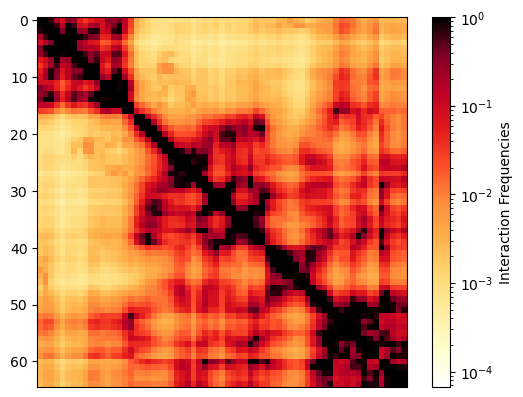

In [73]:
plot_hic(sim_mat);

#### Using the best sample, scan for best cutoff distances/decay rates

In [81]:
r_cs = torch.arange(.1,3.1,.1)
sigmas = torch.arange(1,4.1,.1)

pccs2 = torch.empty(len(r_cs),len(sigmas),device=best_sample.device,dtype=best_sample.batch_dtype)

exp_mat = exp_mat.to(best_sample.device) 
for i,r_c in enumerate(r_cs):
    for j,sigma in enumerate(sigmas):
        sim_mat = best_sample.contact_probabilities(r_c=r_c,sigma=sigma)
        pccs2[i,j] = get_pcc(exp_mat,sim_mat)
pccs2 = pccs2.cpu().numpy()

/state/partition1/slurm_tmp/24555040.0.0/ipykernel_1921463/4649296.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_ticklabels(ax.get_xticklabels(),sigmas,y_axis=False))
/state/partition1/slurm_tmp/24555040.0.0/ipykernel_1921463/4649296.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ticklabels(ax.get_yticklabels(),r_cs,y_axis=True))


Text(0, 0.5, '$r_c$')

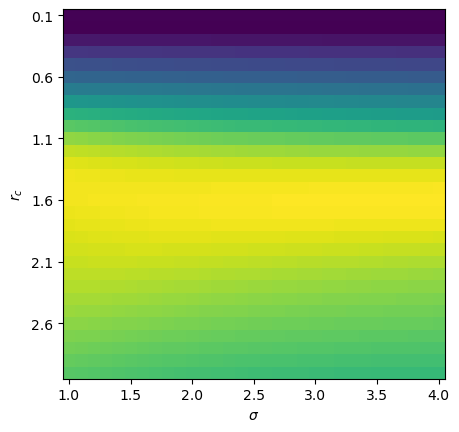

In [119]:
def new_ticklabels(ticklabels,true_range,y_axis=True): 
    for t in ticklabels[1:-1]: 
        t.set_text(f'{round(float(true_range[int(t.get_position()[int(y_axis)])]),4)}')
    return ticklabels
        

fig = plt.figure()
ax = fig.add_subplot(111) 
ax.matshow(pccs2)

ax.set_xticklabels(new_ticklabels(ax.get_xticklabels(),sigmas,y_axis=False))
ax.set_yticklabels(new_ticklabels(ax.get_yticklabels(),r_cs,y_axis=True))

ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)

ax.set_xlabel('$\\sigma$')
ax.set_ylabel('$r_c$')


In [123]:
best = np.where(pccs2==pccs2.max())
best_r_c = r_cs[best[0]]
best_sigma = sigmas[best[1]]

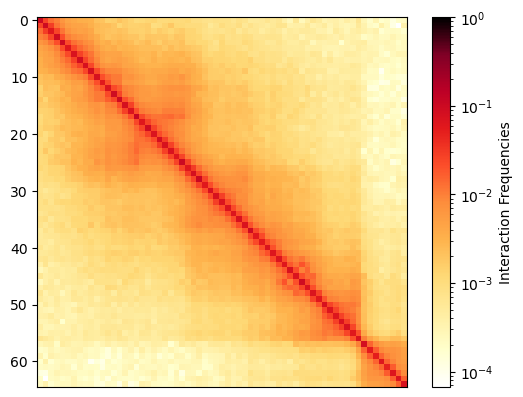

In [124]:
plot_hic(exp_mat);

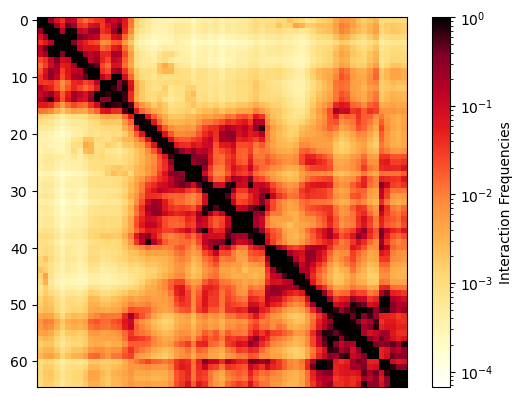

In [144]:
sim_mat = best_sample.contact_probabilities(r_c=best_r_c.to(best_sample.device),sigma=best_sigma.to(best_sample.device))
plot_hic(sim_mat);

#### Check if shifting helps 

In [150]:
shifts = range(-200000,201000,1000)
pccs3 = torch.empty(len(shifts),dtype=best_sample.batch_dtype,device=best_sample.device)

shifts = torch.arange(-200000,201000,1000)
for shift in range(-200000,201000,1000):

    emb_idx_ = list(emb_idx[best_region_idx])
    emb_idx_[-1]+= 130000
    emb_idx_ = tuple(emb_idx_) 
    exp_mat_shifted = fetch_at_20kb(clr,emb_idx_,remove_diagonal=False)
    exp_mat_shifted = exp_mat_shifted.to(dtype=best_sample.batch_dtype,device=best_sample.device)

    pccs3[i] = get_pcc(exp_mat_shifted,sim_mat)

pccs3 = pccs3.cpu().numpy()
best_shift = shifts[np.where(pccs3 == pccs3.max())[0]]

#### Best rc/sigma when including this shift

In [161]:
emb_idx_ = list(emb_idx[best_region_idx])
emb_idx_[-1]+= best_shift
emb_idx_ = tuple(emb_idx_) 
exp_mat = fetch_at_20kb(clr,emb_idx_,remove_diagonal=False).to(device=best_sample.device,dtype=best_sample.batch_dtype)

In [162]:
r_cs = torch.arange(.1,3.1,.1)
sigmas = torch.arange(1,4.1,.1)

pccs2 = torch.empty(len(r_cs),len(sigmas),device=best_sample.device,dtype=best_sample.batch_dtype)

exp_mat = exp_mat.to(best_sample.device) 
for i,r_c in enumerate(r_cs):
    for j,sigma in enumerate(sigmas):
        sim_mat = best_sample.contact_probabilities(r_c=r_c,sigma=sigma)
        pccs2[i,j] = get_pcc(exp_mat,sim_mat)
pccs2 = pccs2.cpu().numpy()

/state/partition1/slurm_tmp/24555040.0.0/ipykernel_1921463/4649296.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_ticklabels(ax.get_xticklabels(),sigmas,y_axis=False))
/state/partition1/slurm_tmp/24555040.0.0/ipykernel_1921463/4649296.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ticklabels(ax.get_yticklabels(),r_cs,y_axis=True))


Text(0, 0.5, '$r_c$')

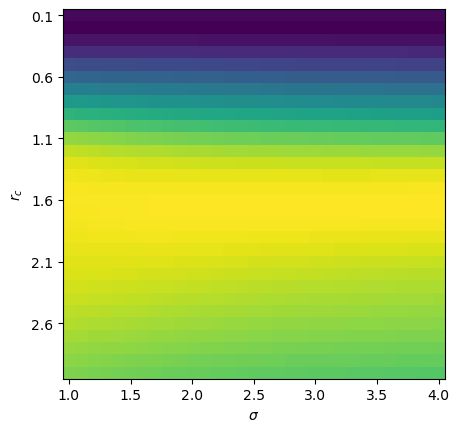

In [163]:
def new_ticklabels(ticklabels,true_range,y_axis=True): 
    for t in ticklabels[1:-1]: 
        t.set_text(f'{round(float(true_range[int(t.get_position()[int(y_axis)])]),4)}')
    return ticklabels
        

fig = plt.figure()
ax = fig.add_subplot(111) 
ax.matshow(pccs2)

ax.set_xticklabels(new_ticklabels(ax.get_xticklabels(),sigmas,y_axis=False))
ax.set_yticklabels(new_ticklabels(ax.get_yticklabels(),r_cs,y_axis=True))

ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)

ax.set_xlabel('$\\sigma$')
ax.set_ylabel('$r_c$')


In [164]:
best = np.where(pccs2==pccs2.max())
best_r_c = r_cs[best[0]]
best_sigma = sigmas[best[1]]

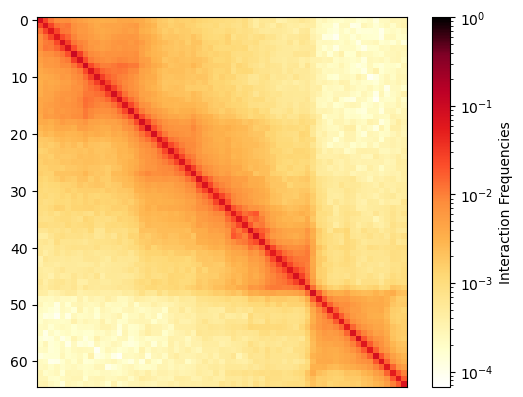

In [166]:
plot_hic(exp_mat);

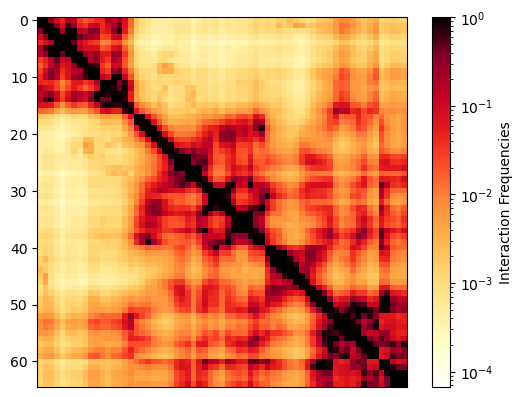

In [165]:
sim_mat = best_sample.contact_probabilities(r_c=best_r_c.to(best_sample.device),sigma=best_sigma.to(best_sample.device))
plot_hic(sim_mat);

In [167]:
emb_idx[0]

(1300000, '1', 780000)

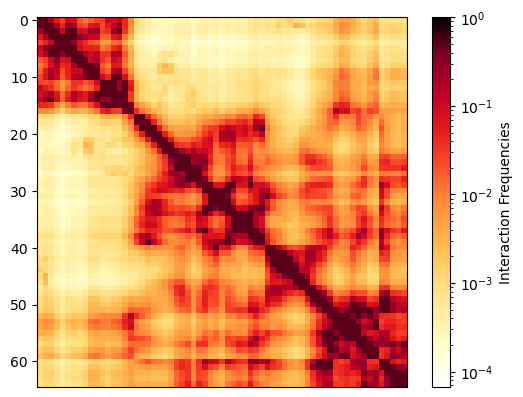

In [174]:
sim_mat = best_sample.contact_probabilities(r_c=1.5,sigma=0)#r_c=best_r_c.to(best_sample.device),sigma=best_sigma.to(best_sample.device))
plot_hic(sim_mat);

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f5bfdb4b130>)

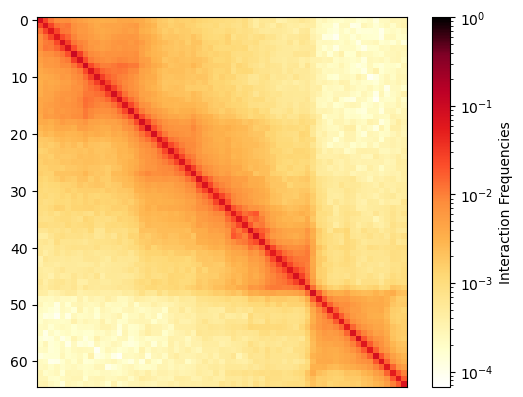

In [175]:
emb_idx_ = list(emb_idx[0])
emb_idx_[-1]+=best_shift#176000
emb_idx_ = tuple(emb_idx_) 
exp_map_ = fetch_at_20kb(clr,emb_idx_,remove_diagonal=False) 
plot_hic(exp_map_) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f5be5041de0>)

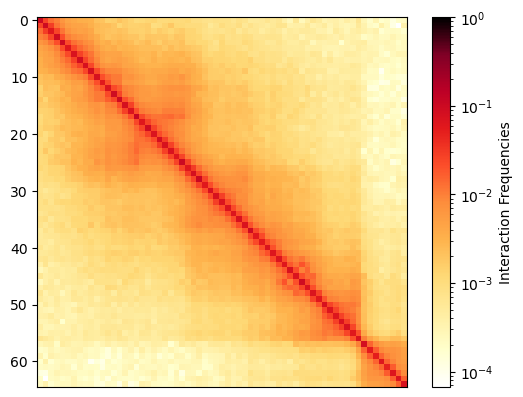

In [178]:
emb_idx_ = list(emb_idx[0])
emb_idx_[-1]+=0#best_shift#176000
emb_idx_ = tuple(emb_idx_) 
exp_map_ = fetch_at_20kb(clr,emb_idx_,remove_diagonal=False) 
plot_hic(exp_map_) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f5be54f4c10>)

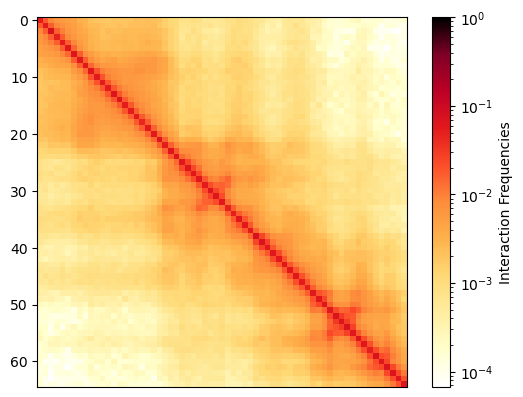

In [168]:
exp_map_ = fetch_at_20kb(clr,emb_idx[1000],remove_diagonal=False) 
plot_hic(exp_map_) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f5bfdd83550>)

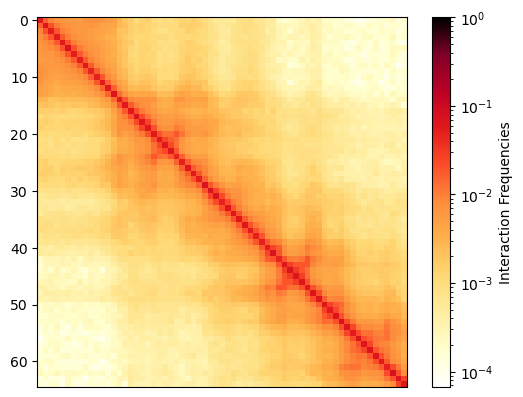

In [171]:
emb_idx_ = list(emb_idx[1000])
emb_idx_[-1]+=best_shift#176000
emb_idx_ = tuple(emb_idx_) 
exp_map_ = fetch_at_20kb(clr,emb_idx_,remove_diagonal=False) 
plot_hic(exp_map_) 

#### Work with Tan data 

In [ ]:
Shift Tan_Data